In [138]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
import wandb
from datetime import timedelta
import matplotlib.pyplot as plt

In [ ]:
# wandb.init(
#     entity="gsu-dmlab",
#     project="SEPCFE",  # You choose the project name
#     name="Native_Guide_Exp1_EDA_ModelTraining",  # Give each run a name
# )

In [139]:


label_file = '../../data/raw/class_labels.csv'
data_dir = '../../data/raw/data/'

df_labels = pd.read_csv(label_file)
label_map = dict(zip(df_labels['File'], df_labels['Label']))

X_list = []
y = []
start_offset_min=300
end_offset_min=660
cols_to_keep = ['p3_flux_ic', 'p5_flux_ic', 'p7_flux_ic', 'long']
timestamps_list=[]
filenames=[]
for fname in os.listdir(data_dir):
    if fname.endswith('.csv') and fname in label_map and fname!='2005-09-07_14-25.csv' :
        file_path = os.path.join(data_dir, fname)
        ts_df = pd.read_csv(file_path,sep=",")
        ts_df = ts_df.rename(columns={'time_tag': 'time_stamp'})
        ts_df['time_stamp'] = pd.to_datetime(ts_df['time_stamp'], format='%Y-%m-%d %H:%M:%S')
        event_start = ts_df['time_stamp'].iloc[0] + timedelta(minutes=start_offset_min)
        event_end = ts_df['time_stamp'].iloc[0] + timedelta(minutes=end_offset_min)
        df_obs = ts_df[(ts_df['time_stamp'] >= event_start) & (ts_df['time_stamp'] < event_end)].copy()
        # print(df_obs[cols_to_keep])
        # df_obs['minutes'] = (df_obs['time_stamp'] - event_start).dt.total_seconds() / 60
        #each column becomes a pd.Series
        row_dict = {col: pd.Series(df_obs[col].values) for col in cols_to_keep}
        X_list.append(row_dict)
        y.append(label_map[fname])

# Convert list of dicts into nested DataFrame (panel format)
X = pd.DataFrame(X_list)
print(X.head())
y = np.array(y)
print(y[0:10])

                                                                                                                                                                                         p3_flux_ic  \
0             0      0.1772
1      0.1600
2      0.1480
3      0.1360
4      0.1240
        ...  
355    0.1431
356    0.1550
357    0.1518
358    0.1486
359    0.1454
Length: 360, dtype: float64   
1  0      0.23736
1      0.19104
2      0.14472
3      0.09840
4      0.12592
        ...   
355    0.13200
356    0.13700
357    0.14200
358    0.14700
359    0.14260
Length: 360, dtype: float64   
2             0      0.2856
1      0.2392
2      0.1928
3      0.1464
4      0.1000
        ...  
355    0.1064
356    0.1153
357    0.1242
358    0.1331
359    0.1420
Length: 360, dtype: float64   
3             0      0.1932
1      0.2008
2      0.2084
3      0.2160
4      0.3144
        ...  
355    0.3428
356    0.3352
357    0.3276
358    0.3200
359    0.2952
Length: 360, dtype: float64   
4    

In [140]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.17, random_state=42, stratify=y_temp)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (2039, 4)
Validation shape: (418, 4)
Test shape: (434, 4)


In [141]:
from sktime.datatypes._panel._convert import from_nested_to_3d_numpy

X_train_3D = from_nested_to_3d_numpy(X_train)  # shape: (n_samples, n_channels, n_timepoints)
X_val_3D  = from_nested_to_3d_numpy(X_val)
X_test_3D  = from_nested_to_3d_numpy(X_test)



In [ ]:
# from sktime.classification.knn import KNeighborsTimeSeriesClassifier
#
# clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
# clf.fit(X_train, y_train)
#
# # Validation
# y_val_pred = clf.predict(X_val)
# from sklearn.metrics import accuracy_score
# print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
#
# # Test
# y_test_pred = clf.predict(X_test)
# print("Test accuracy:", accuracy_score(y_test, y_test_pred))


In [142]:
from tslearn.neighbors import KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier
import joblib
model = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw",)
model.fit(X_train_3D, y_train)

joblib.dump(model, '../../models/KNN_1_TS__classifier_v1.2.pkl')

['../../models/KNN_1_TS__classifier_v1.2.pkl']

In [144]:
from sklearn.metrics import accuracy_score

y_val_pred = model.predict(X_val_3D)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# Test
y_pred = model.predict(X_test_3D)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Validation accuracy: 0.9521531100478469
Test accuracy: 0.9516129032258065


In [28]:
# #finding the nearest unlike neighbour. NB will need to account for regularization # this is for Univariate timeseries
# def native_guide_retrieval(query, predicted_label, distance, n_neighbors):
#
#     df = pd.DataFrame(y_train, columns = ['label'])
#     df.index.name = 'index'
#     #df[df['label'] == 1].index.values, df[df['label'] != 1].index.values
#
#     ts_length = X_train.shape[1]
#
#     knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)
#
#     knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
#
#     dist,ind = knn.kneighbors(query.reshape(1,ts_length), return_distance=True)
#     return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]

In [145]:


def native_guide_retrieval_mvts(query, predicted_label, distance, n_neighbors):
    """
    Retrieve nearest unlike neighbors for a multivariate time series query.

    query: array of shape (n_channels, n_timepoints)
    predicted_label: the label to avoid
    distance: distance metric, e.g., 'dtw'
    n_neighbors: number of neighbors to retrieve
    """
    # Find indices of unlike neighbors
    unlike_indices = np.where(y_train != predicted_label)[0]  # numpy indexing

    # Subset X_train_3D along sample axis
    X_unlike = X_train_3D[unlike_indices, :, :]  # shape: (n_unlike, n_channels, n_timepoints)

    # Initialize KNN
    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric=distance)
    knn.fit(X_unlike)

    # Reshape query to (1, n_channels, n_timepoints)
    query_reshaped = query.reshape(1, query.shape[0], query.shape[1])

    # Compute distances and indices
    dist, ind = knn.kneighbors(query_reshaped, return_distance=True)

    # Map indices back to original X_train indices
    neighbor_indices = unlike_indices[ind[0]]

    return dist[0], neighbor_indices


In [146]:
# Pick a test sample, e.g., the 12th sample
query = X_test_3D[3]  # shape (n_channels, n_timepoints)

# Predicted label for this test sample
pred_label = y_pred[3]

# Call the function
distances, neighbor_indices = native_guide_retrieval_mvts(
    query=query,
    predicted_label=pred_label,
    distance='dtw',
    n_neighbors=3
)

# Print results
print("Distances to nearest unlike neighbors:", distances)
print("Indices of these unlike neighbors in X_train:", neighbor_indices)
print("Labels of these unlike neighbors:", y_train[neighbor_indices])


Distances to nearest unlike neighbors: [1.45976064 1.51993018 1.56308088]
Indices of these unlike neighbors in X_train: [1380 1754  806]
Labels of these unlike neighbors: [1 1 1]


In [148]:
y_pred[3], y_train[1380], y_test[3]

(0, 1, 0)

In [149]:
import matplotlib.pyplot as plt

def plot_query(query,query_label):
    n_channels = query.shape[0]
    plt.figure(figsize=(12, 3 * n_channels))
    for ch in range(n_channels):
        plt.subplot(n_channels, 1, ch+1)
        # Plot query
        plt.plot(query[ch], label=f"Query (Class Label:{query_label})", color='red', linewidth=2)
        plt.title(f"Channel {ch+1} ")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()

    plt.tight_layout()
    plt.show()


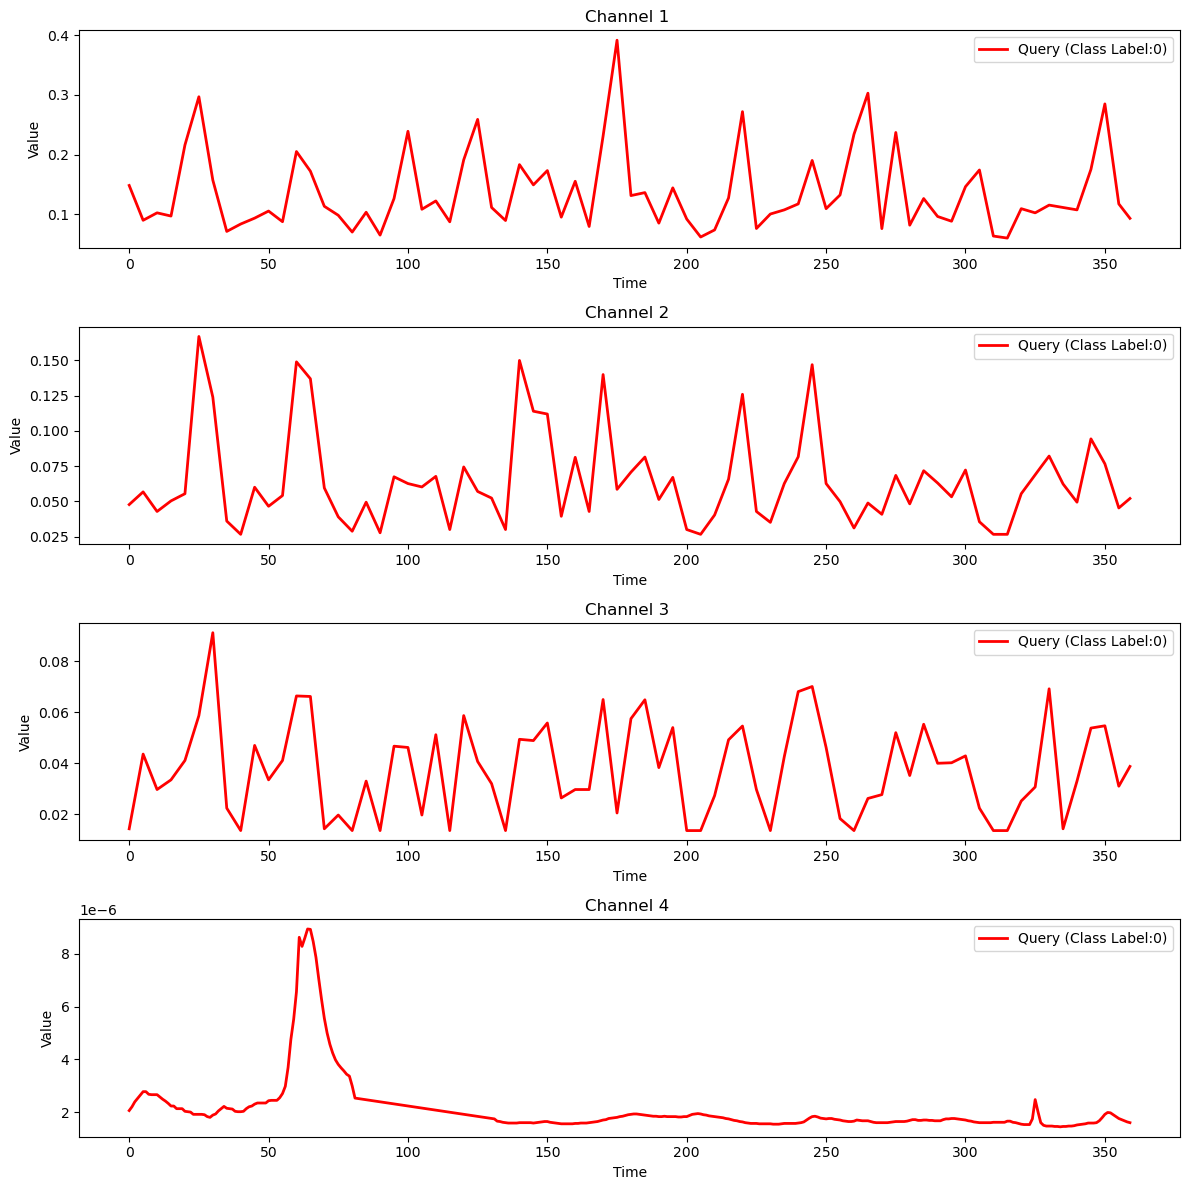

In [150]:
plot_query(query=X_test_3D[3],
    query_label=y_test[3])

In [151]:
import matplotlib.pyplot as plt

def plot_query_and_neighbors(query,query_label, X_train_3D,y_train, neighbor_indices, title_suffix=""):
    """
    Plot the query time series and its nearest unlike neighbors.

    query: array of shape (n_channels, n_timepoints)
    X_train_3D: array of shape (n_samples, n_channels, n_timepoints)
    neighbor_indices: indices of neighbors in X_train_3D
    title_suffix: optional string to append to the plot title
    """
    n_channels = query.shape[0]

    plt.figure(figsize=(12, 3 * n_channels))

    for ch in range(n_channels):
        plt.subplot(n_channels, 1, ch+1)

        # Plot query
        plt.plot(query[ch], label=f"Query (Class Label:{query_label})", color='red', linewidth=2)

        # Plot each neighbor
        for i, idx in enumerate(neighbor_indices):
            plt.plot(X_train_3D[idx, ch, :], label=f"Unlike Nearest Neighbor {i+1}(Class Label:{y_train[idx]})", linestyle='--')

        plt.title(f"Channel {ch+1} {title_suffix}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()

    plt.tight_layout()
    plt.show()


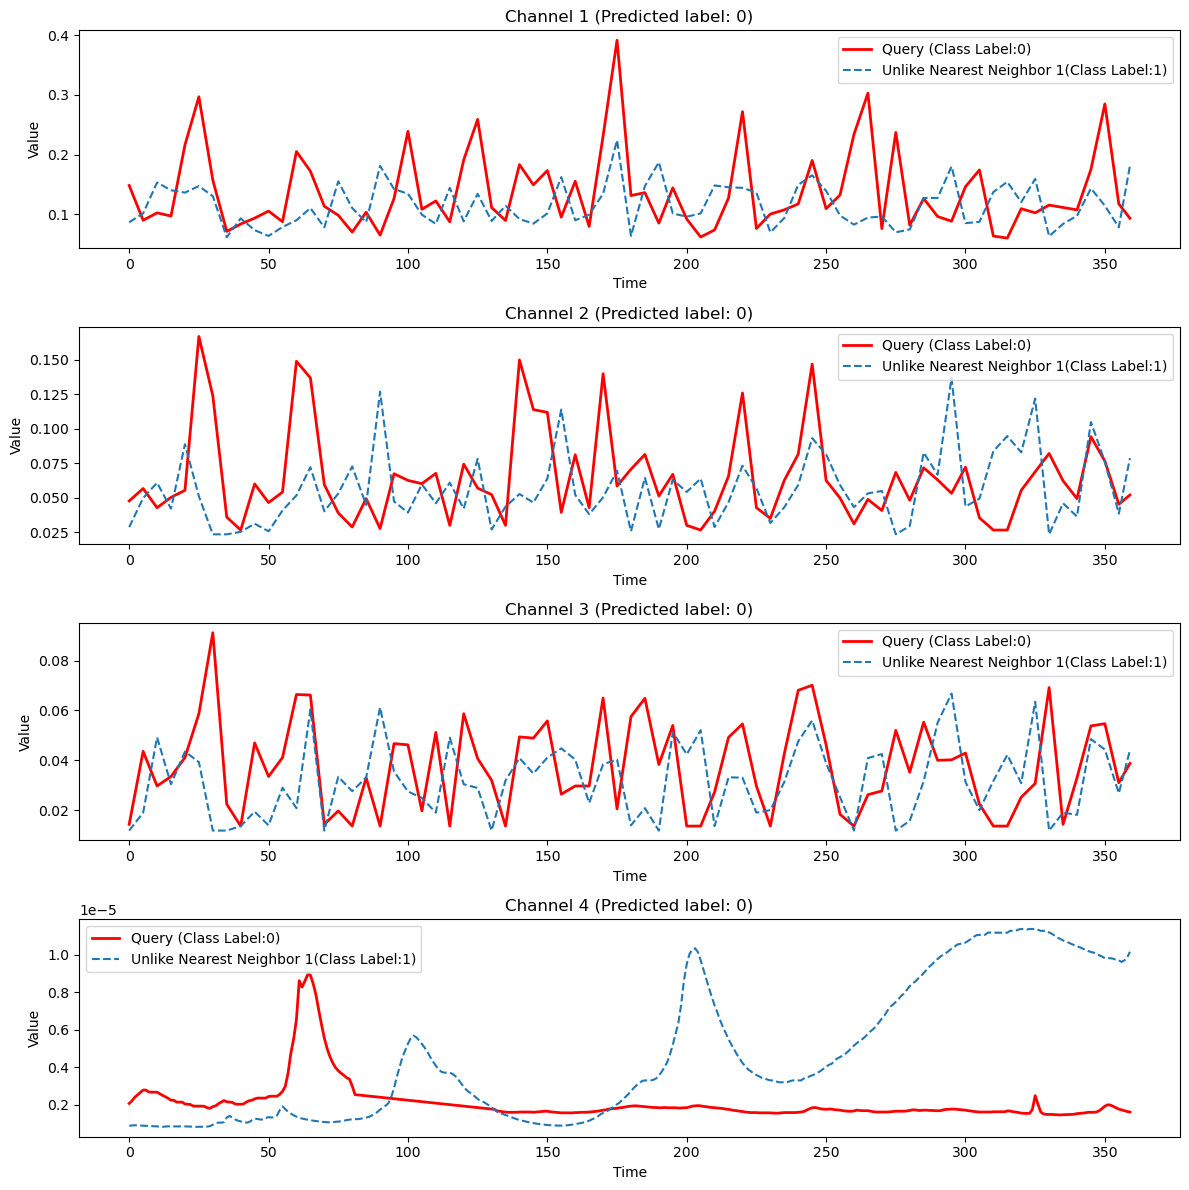

In [152]:
# Using the previous example
plot_query_and_neighbors(
    query=X_test_3D[3],
    query_label=y_test[3],
    X_train_3D=X_train_3D,
    y_train=y_train,
    neighbor_indices=[1380],
    title_suffix=f"(Predicted label: {pred_label})"
)


In [153]:
def target_mvts(instance_3d, model):
    """
    Find the second-most likely class for a multivariate time series.
    instance_3d: shape (n_channels, n_timepoints)
    model: trained tslearn classifier
    """
    # Add batch dimension: (1, n_channels, n_timepoints)
    instance_batch = instance_3d[np.newaxis, :, :]

    # Get class probabilities
    probs = model.predict_proba(instance_batch)[0]

    # Return index of the second-highest probability
    target_class = np.argsort(probs)[-2]
    return target_class


In [154]:
second_class = target_mvts(X_test_3D[3], model)
pred_class = y_pred[3]

print("Second Most likely class by probabilities:", second_class)
print("Predicted class:", pred_class)


Second Most likely class by probabilities: 1
Predicted class: 0


In [155]:
from tslearn.barycenters import dtw_barycenter_averaging
query = X_test_3D[3]       # shape: (n_channels, n_timepoints)
beta = 0
insample_cf = X_train_3D[1380] # shape: (n_channels, n_timepoints)
target = target_mvts(query,model)      # predicted target class
pred_threshold = 0.5

# Generate initial barycenter
generated_cf = dtw_barycenter_averaging([query, insample_cf],
                                        weights=np.array([1-beta, beta]))

# Predict probability for the target class
prob_target = model.predict_proba(generated_cf[np.newaxis, :, :])[0][target]

# Incrementally update beta until probability crosses threshold
while prob_target < pred_threshold and beta <= 1.0:
    beta += 0.01
    generated_cf = dtw_barycenter_averaging([query, insample_cf],
                                            weights=np.array([1-beta, beta]))
    prob_target = model.predict_proba(generated_cf[np.newaxis, :, :])[0][target]

print("Beta used for CF:", beta)
print("Probability for target class:", prob_target)


Beta used for CF: 0.3300000000000001
Probability for target class: 1.0


In [156]:
X_test_3D[3]

array([[1.48000000e-01, 1.36300000e-01, 1.24600000e-01, ...,
        1.04880000e-01, 9.88200000e-02, 9.27600000e-02],
       [4.78000000e-02, 4.96000000e-02, 5.14000000e-02, ...,
        4.87600000e-02, 5.04400000e-02, 5.21200000e-02],
       [1.43000000e-02, 2.01600000e-02, 2.60200000e-02, ...,
        3.48800000e-02, 3.68200000e-02, 3.87600000e-02],
       [2.07142857e-06, 2.21428571e-06, 2.40000000e-06, ...,
        1.68571429e-06, 1.64285714e-06, 1.61428571e-06]])

In [95]:
generated_cf

array([[1.80215163e-01, 1.74252472e-01, 1.68289781e-01, ...,
        1.55511961e-01, 1.66005950e-01, 1.76499939e-01],
       [9.51472856e-02, 9.06312384e-02, 8.61151912e-02, ...,
        5.20765401e-02, 5.48758309e-02, 5.76751217e-02],
       [2.81609572e-02, 2.68992156e-02, 2.56374741e-02, ...,
        2.46373185e-02, 2.60454269e-02, 2.74535353e-02],
       [8.33627286e-07, 8.32621857e-07, 8.29169000e-07, ...,
        2.22695286e-06, 2.17998143e-06, 2.14293000e-06]])

In [157]:
# Reshape to add the sample dimension
generated_cf_reshaped = generated_cf.reshape(1, *generated_cf.shape)  # (1, n_channels, n_timepoints)

# Predicted label
generated_cf_label = model.predict(generated_cf_reshaped)[0]

# Predicted probabilities (optional)
pred_probs = model.predict_proba(generated_cf_reshaped)[0]

print("Predicted label for Generated CF:", generated_cf_label)
print("Predicted probabilities:", pred_probs)
print("Most likely class:", pred_probs.argmax())


Predicted label for Generated CF: 1
Predicted probabilities: [0. 1.]
Most likely class: 1


In [164]:
import matplotlib.pyplot as plt

def plot_mvts_cf(query, query_label,generated_cf,generated_cf_label, title="Query vs Counterfactual"):
    """
    query: np.ndarray of shape (n_channels, n_timepoints)
    generated_cf: np.ndarray of shape (n_channels, n_timepoints)
    """
    n_channels = query.shape[0]
    timepoints = query.shape[1]

    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2 * n_channels), sharex=True)

    if n_channels == 1:
        axes = [axes]  # Make it iterable if only 1 channel

    for i,ch in enumerate(cols_to_keep):
        axes[i].plot(range(timepoints), query[i], label=f"Query (class_label:{query_label})", alpha=0.7)
        axes[i].plot(range(timepoints), generated_cf[i], label=f"Counterfactual (class label:{generated_cf_label})", alpha=0.7, linestyle="--")
        axes[i].set_title(f"{ch}")
        axes[i].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


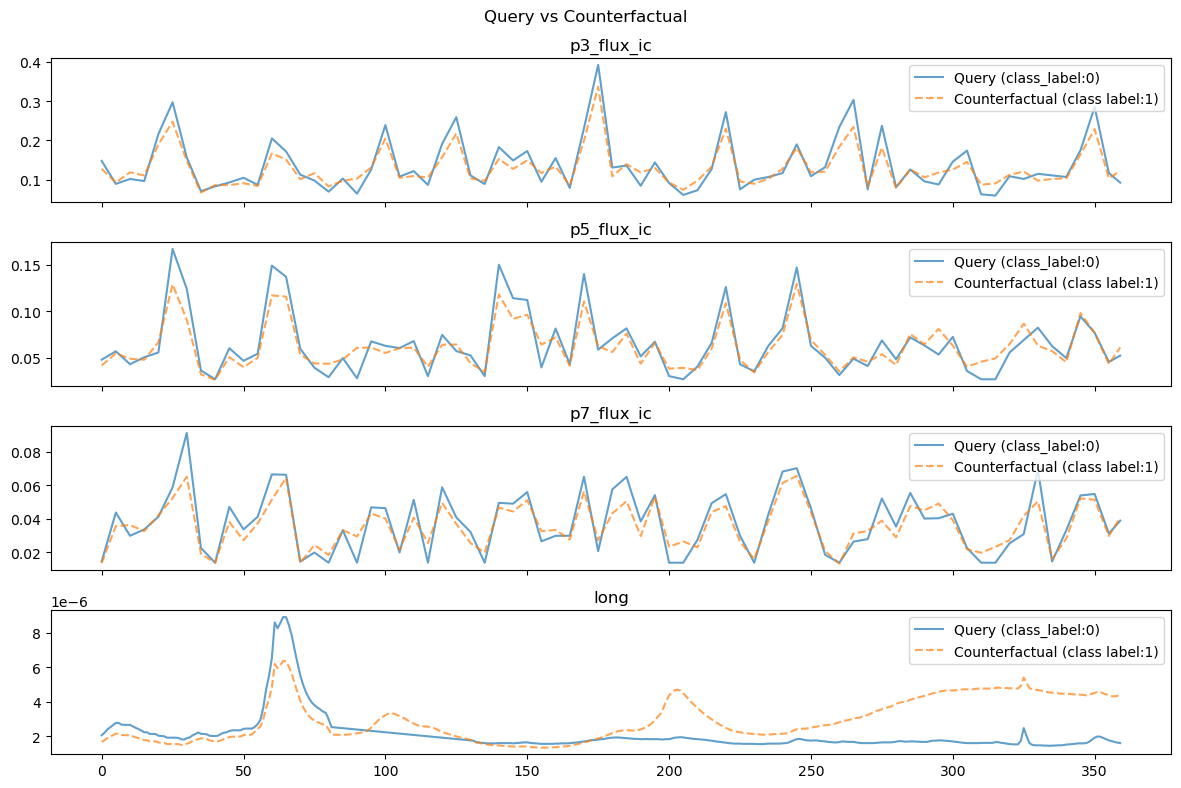

In [165]:
plot_mvts_cf(X_test_3D[3],y_test[3],generated_cf,generated_cf_label)

In [161]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# query        = X_test_3D[3]      # shape (n_channels, n_timepoints)
# nun_cf       = X_train_3D[1380]   # nearest unlike neighbour
# generated_cf = generated_cf      # counterfactual
#
# n_channels = query.shape[0]
# channel_names = cols_to_keep
#
# # Create a single figure + axis
# fig, ax = plt.subplots(figsize=(28, 16), facecolor='white')
#
# # Plot all channels on the same axis
# for ch in range(n_channels-1):
#     ax.plot(query[ch], label=f"Query {channel_names[ch]}", linewidth=2,color="#FF0000")
#     ax.plot(nun_cf[ch], label=f"NUN {channel_names[ch]}", linestyle="--",color="#1b5c0c")
#     ax.plot(generated_cf[ch], label=f"Generated CF {channel_names[ch]}", linestyle=":",color="#FFA500")
#
# # Styling
# ax.set_title("Query vs NUN vs CF (all channels)", fontsize=18)
# ax.set_xlabel("Time", fontsize=14)
# ax.set_ylabel("Value", fontsize=14)
# ax.grid(True)
# ax.set_yscale("log")
#
# # Legend
# ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=12)
#
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


In [162]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# query        = X_test_3D[3]      # shape (n_channels, n_timepoints)
# nun_cf       = X_train_3D[304]   # nearest unlike neighbour
# generated_cf = generated_cf      # counterfactual
#
# n_channels = query.shape[0]
# channel_names = cols_to_keep
#
# # Create a single figure + axis
# fig, ax = plt.subplots(figsize=(28, 16), facecolor='white')
#
# # Plot all channels on the same axis
# for ch in range(n_channels-1):
#     ax.plot(query[ch], label=f"Query {channel_names[ch]}", linewidth=2,color="#FF0000")
#     # ax.plot(nun_cf[ch], label=f"NUN {channel_names[ch]}", linestyle="--",color="#1b5c0c")
#     ax.plot(generated_cf[ch], label=f"Generated CF {channel_names[ch]}", linestyle=":",color="#FFA500")
#
# # Styling
# ax.set_title("Query vs  CF (all channels)", fontsize=18)
# ax.set_xlabel("Time", fontsize=14)
# ax.set_ylabel("Value", fontsize=14)
# ax.grid(True)
# # ax.set_yscale("log")
#
# # Legend
# ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=12)
#
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


Example 2

In [163]:
# query_index=1
# query = X_test_3D[query_index]  # shape (n_channels, n_timepoints)
# # Predicted label for this test sample
# pred_label = y_pred[query_index]
# # Call the function
# distances, neighbor_indices = native_guide_retrieval_mvts(
#     query=query,
#     predicted_label=pred_label,
#     distance='dtw',
#     n_neighbors=1
# )
# nun_index = neighbor_indices
# print("Distances to nearest unlike neighbors:", distances)
# print("Indices of these unlike neighbors in X_train:", neighbor_indices)
# print("Labels of these unlike neighbors:", y_train[neighbor_indices])
# print("Label of Query Instance:",pred_label)


In [135]:
# from tslearn.barycenters import dtw_barycenter_averaging
#       # shape: (n_channels, n_timepoints)
# beta = 0
# insample_cf = X_train_3D[nun_index] # shape: (n_channels, n_timepoints)
# target = target_mvts(query,model)      # predicted target class
# pred_threshold = 0.5
#
# # Generate initial barycenter
# generated_cf = dtw_barycenter_averaging(np.stack([query, insample_cf]),
#                                         weights=np.array([1-beta, beta]))
#
# # Predict probability for the target class
# prob_target = model.predict_proba(generated_cf[np.newaxis, :, :])[0][target]
#
# # Incrementally update beta until probability crosses threshold
# while prob_target < pred_threshold and beta <= 1.0:
#     beta += 0.01
#     generated_cf = dtw_barycenter_averaging(np.stack([query, insample_cf]),
#                                             weights=np.array([1-beta, beta]))
#     prob_target = model.predict_proba(generated_cf[np.newaxis, :, :])[0][target]
#
# print("Beta used for CF:", beta)
# print("Probability for target class:", prob_target)


ValueError: all input arrays must have the same shape

In [ ]:
# # Reshape to add the sample dimension
# generated_cf_reshaped = generated_cf.reshape(1, *generated_cf.shape)  # (1, n_channels, n_timepoints)
#
# # Predicted label
# generated_cf_label = model.predict(generated_cf_reshaped)[0]
#
# # Predicted probabilities (optional)
# pred_probs = model.predict_proba(generated_cf_reshaped)[0]
#
# print("Predicted label for Generated CF:", generated_cf_label)
# print("Predicted probabilities:", pred_probs)
# print("Most likely class:", pred_probs.argmax())

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
#
# query        = X_test_3D[query_index]      # shape (n_channels, n_timepoints)
# nun_cf       = X_train_3D[nun_index]   # nearest unlike neighbour
# generated_cf = generated_cf      # counterfactual
#
# n_channels = query.shape[0]
# channel_names = cols_to_keep
#
# # Create a single figure + axis
# fig, ax = plt.subplots(figsize=(28, 16), facecolor='white')
#
# # Plot all channels on the same axis
# for ch in range(n_channels-1):
#     ax.plot(query[ch], label=f"Query {channel_names[ch]}", linewidth=2,color="#FF0000")
#     ax.plot(nun_cf[ch], label=f"NUN {channel_names[ch]}", linestyle="--",color="#1b5c0c")
#     ax.plot(generated_cf[ch], label=f"Generated CF {channel_names[ch]}", linestyle=":",color="#FFA500")
#
# # Styling
# ax.set_title("Query vs NUN vs CF (all channels)", fontsize=18)
# ax.set_xlabel("Time", fontsize=14)
# ax.set_ylabel("Value", fontsize=14)
# ax.grid(True)
# ax.set_yscale("log")
#
# # Legend
# ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False, fontsize=12)
#
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


In [ ]:
wandb.finish()